In [1]:
# Python 3
import http.client, urllib.parse
import json
import pprint
import yfinance
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import sklearn.linear_model as SKmodels
import joblib

# API keys

In [2]:
API_STOCK_DATA = "Ab0Eq9OSOkVaNe9eluoMjkxSgnrFk46h08ghta6w"
API_ALPHA_VANTAGE = "Y55JGW1SYPKKETDD"

# Stock data API

In [3]:
# conn = http.client.HTTPSConnection('api.stockdata.org')
#
# params = urllib.parse.urlencode({
#     'api_token': API_STOCK_DATA,
#     'symbols': 'AAPL',
#     'interval': 'minute',
#     'date_from': '2021-01-01',
#     'date_to': '2022-01-01'
#     })
#
# conn.request('GET', '/v1/data/intraday?{}'.format(params))
#
# res = conn.getresponse()
# data = res.read()
# json.loads(data.decode('utf-8'))

# Alpha vantage

In [4]:
# url = f'https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&symbol=IBM&interval=1min&apikey={API_ALPHA_VANTAGE}'
# r = requests.get(url)
# dataVIX = r.json()
# dataVIX

# Yfinance

,VIX_Open
Datetime,
2022-04-21 14:31:00+01:00,19.920000
2022-04-21 14:32:00+01:00,19.870001
2022-04-21 14:33:00+01:00,19.860001
2022-04-21 14:34:00+01:00,19.860001
2022-04-21 14:35:00+01:00,19.920000
...,...
2022-04-29 16:40:00+01:00,30.190001
2022-04-29 16:41:00+01:00,30.070000
2022-04-29 16:42:00+01:00,29.910000


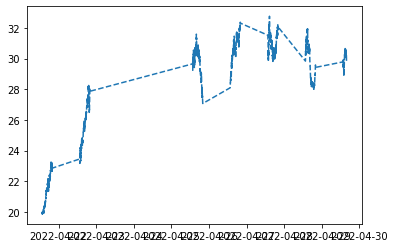

In [5]:
# Download VIX information
ticker = yfinance.Ticker('^VIX')
VIX = ticker.history(interval='1m', period='7d')
VIX.index = pd.to_datetime(VIX.index).tz_convert(tz='Europe/London')
VIX.columns = [f"VIX_{_}" for _ in VIX.columns]
plt.plot(VIX.VIX_Open, '--')
VIX = VIX[["VIX_Open"]]
VIX

,CHFJPY_Open
Datetime,
2022-04-21 00:00:00+01:00,134.860001
2022-04-21 00:01:00+01:00,134.858002
2022-04-21 00:02:00+01:00,134.809998
2022-04-21 00:03:00+01:00,134.811005
2022-04-21 00:04:00+01:00,134.822006
...,...
2022-04-29 16:40:00+01:00,133.442001
2022-04-29 16:41:00+01:00,133.440994
2022-04-29 16:42:00+01:00,133.494995


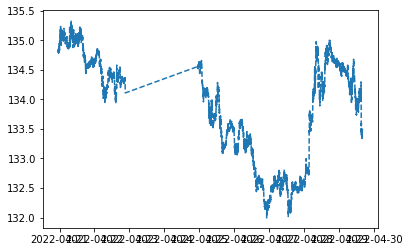

In [6]:
# Download CHFJPY information
ticker = yfinance.Ticker('CHFJPY=X')
CHFJPY = ticker.history(interval='1m', period='7d').iloc[:-15]
CHFJPY.index = pd.to_datetime(CHFJPY.index).tz_convert(tz='Europe/London')
CHFJPY.columns = [f"CHFJPY_{_}" for _ in CHFJPY.columns]
plt.plot(CHFJPY.CHFJPY_Open, '--')
CHFJPY = CHFJPY[["CHFJPY_Open"]]
CHFJPY

,GOLD_Open
Datetime,
2022-04-22 05:00:00+01:00,1952.199951
2022-04-22 05:01:00+01:00,1952.400024
2022-04-22 05:02:00+01:00,1952.199951
2022-04-22 05:03:00+01:00,1952.300049
2022-04-22 05:04:00+01:00,1952.199951
...,...
2022-04-29 16:31:00+01:00,1907.199951
2022-04-29 16:32:00+01:00,1906.900024
2022-04-29 16:33:00+01:00,1906.699951


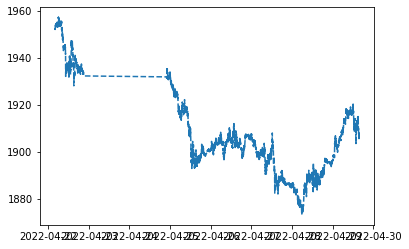

In [7]:
# Download Gold information
ticker = yfinance.Ticker('GC=F')
GOLD = ticker.history(interval='1m', period='7d').iloc[:-15]
GOLD.index = pd.to_datetime(GOLD.index).tz_convert(tz='Europe/London')
GOLD.columns = [f"GOLD_{_}" for _ in GOLD.columns]
plt.plot(GOLD.GOLD_Open, '--')
GOLD = GOLD[["GOLD_Open"]]
GOLD

In [8]:
# Merge both dataFrames. Cut part with causes by yahooFinance shift of VIX
merged = CHFJPY.merge(VIX, left_index=True, right_index=True, how='left')
nan = np.any(merged.isna(), axis=1)
nan = nan.where(np.logical_not(nan)).first_valid_index()
merged = merged.loc[nan:]
merged['FiniteVixData'] = np.any(merged.isna(), axis=1)[nan:]
merged[VIX.columns] = merged[VIX.columns].fillna(method='ffill')

merged = merged.merge(GOLD, left_index=True, right_index=True, how='left')
nan = np.any(merged.isna(), axis=1)
nan = nan.where(np.logical_not(nan)).first_valid_index()
merged = merged.loc[nan:]
merged['FiniteGOLDData'] = np.any(merged.isna(), axis=1)[nan:]
merged[GOLD.columns] = merged[GOLD.columns].fillna(method='ffill')
# merged.drop(['CHFJPY_Volume', 'CHFJPY_Dividends',
#              'CHFJPY_Stock Splits', 'VIX_Volume', 'VIX_Dividends', 'VIX_Stock Splits',
#              'GOLD_Stock Splits', 'GOLD_Dividends', 'GOLD_Volume'],
#             axis=1, inplace=True)

del nan
# Create Mean by rolling on rollParam value.
rollParam = 100
CHFJPY_roll = merged.rolling(rollParam)['CHFJPY_Open']
merged['CHFJPY_Vol'] = CHFJPY_roll.std()
merged['CHFJPY_Mean'] = CHFJPY_roll.mean()

VIX_roll = merged.rolling(rollParam)['VIX_Open']
merged['VIX_Vol'] = VIX_roll.std()
merged['VIX_Mean'] = VIX_roll.mean()

GOLD_roll = merged.rolling(rollParam)['GOLD_Open']
merged['GOLD_Vol'] = GOLD_roll.std()
merged['GOLD_Mean'] = GOLD_roll.mean()

merged = merged.iloc[rollParam:]

predictionMean = 10
merged['CHFJPY_Mean_Future'] = merged['CHFJPY_Mean'].shift(-predictionMean)
merged = merged.iloc[:-predictionMean]
del CHFJPY_roll, VIX_roll, GOLD_roll

merged

/var/folders/_r/6hvfrncn0gb3rk22vwnq62gh0000gn/T/ipykernel_1448/296508333.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged['CHFJPY_Mean_Future'] = merged['CHFJPY_Mean'].shift(-predictionMean)


,CHFJPY_Open,VIX_Open,FiniteVixData,GOLD_Open,FiniteGOLDData,CHFJPY_Vol,CHFJPY_Mean,VIX_Vol,VIX_Mean,GOLD_Vol,GOLD_Mean,CHFJPY_Mean_Future
Datetime,,,,,,,,,,,,
2022-04-22 06:40:00+01:00,134.399994,22.850000,True,1953.599976,False,0.130624,134.456130,0.000000,22.8500,0.770602,1953.654000,134.42812
2022-04-22 06:41:00+01:00,134.389999,22.850000,True,1953.500000,False,0.129084,134.453390,0.000000,22.8500,0.760304,1953.665000,134.42475
2022-04-22 06:42:00+01:00,134.380005,22.850000,True,1953.900024,False,0.127569,134.450580,0.000000,22.8500,0.746088,1953.682001,134.42138
2022-04-22 06:43:00+01:00,134.371994,22.850000,True,1953.800049,False,0.125697,134.447510,0.000000,22.8500,0.732987,1953.697001,134.41804
2022-04-22 06:44:00+01:00,134.380005,22.850000,True,1953.800049,False,0.123459,134.444410,0.000000,22.8500,0.717273,1953.713002,134.41418
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-29 16:30:00+01:00,133.354996,30.340000,False,1906.699951,False,0.314010,133.846819,0.538826,30.0906,2.376215,1910.781000,133.78560
2022-04-29 16:31:00+01:00,133.350006,30.180000,False,1907.199951,False,0.317424,133.840150,0.537372,30.0955,2.377717,1910.779999,133.77986
2022-04-29 16:32:00+01:00,133.380005,30.100000,False,1906.900024,False,0.320258,133.833850,0.536542,30.0985,2.390779,1910.770999,133.77499


In [9]:
# merged['Target'] = 1 if (merged['CHFJPY_Mean_Future'] > merged['CHFJPY_Mean']) else 0
merged['Target'] = merged.apply(lambda x: 1 if x.CHFJPY_Mean_Future > x['CHFJPY_Mean'] else 0, axis=1)

In [10]:
train, test = train_test_split(merged, shuffle=False)
scalePandas = MinMaxScaler()
train[train.columns] = scalePandas.fit_transform(train[train.columns])
train


,CHFJPY_Open,VIX_Open,FiniteVixData,GOLD_Open,FiniteGOLDData,CHFJPY_Vol,CHFJPY_Mean,VIX_Vol,VIX_Mean,GOLD_Vol,GOLD_Mean,CHFJPY_Mean_Future,Target
Datetime,,,,,,,,,,,,,
2022-04-22 06:40:00+01:00,0.902850,0.000000,1.0,0.956056,0.0,0.269572,0.957441,0.000000e+00,0.000000,0.097698,0.979490,0.945704,0.0
2022-04-22 06:41:00+01:00,0.899101,0.000000,1.0,0.954869,0.0,0.265708,0.956293,0.000000e+00,0.000000,0.095963,0.979628,0.944292,0.0
2022-04-22 06:42:00+01:00,0.895352,0.000000,1.0,0.959620,0.0,0.261905,0.955116,0.000000e+00,0.000000,0.093568,0.979843,0.942879,0.0
2022-04-22 06:43:00+01:00,0.892347,0.000000,1.0,0.958432,0.0,0.257207,0.953829,0.000000e+00,0.000000,0.091360,0.980032,0.941480,0.0
2022-04-22 06:44:00+01:00,0.895352,0.000000,1.0,0.958432,0.0,0.251590,0.952530,0.000000e+00,0.000000,0.088713,0.980233,0.939862,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-28 08:24:00+01:00,0.844711,0.930444,1.0,0.133017,0.0,0.319241,0.844135,7.531670e-07,0.974585,0.581157,0.029758,0.859380,1.0
2022-04-28 08:25:00+01:00,0.877718,0.930444,1.0,0.133017,0.0,0.317427,0.845610,7.531670e-07,0.974585,0.586095,0.030992,0.860905,1.0
2022-04-28 08:26:00+01:00,0.878473,0.930444,1.0,0.156770,0.0,0.315406,0.847097,7.531670e-07,0.974585,0.597328,0.032441,0.862489,1.0


/var/folders/_r/6hvfrncn0gb3rk22vwnq62gh0000gn/T/ipykernel_1448/3772619759.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  train[list(filter(lambda x: '_Open' in x, train.columns))].hist(ax=ax, bins=100)
/var/folders/_r/6hvfrncn0gb3rk22vwnq62gh0000gn/T/ipykernel_1448/3772619759.py:8: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  train[list(filter(lambda x: '_Vol' in x, train.columns))].hist(ax=ax, bins=100)


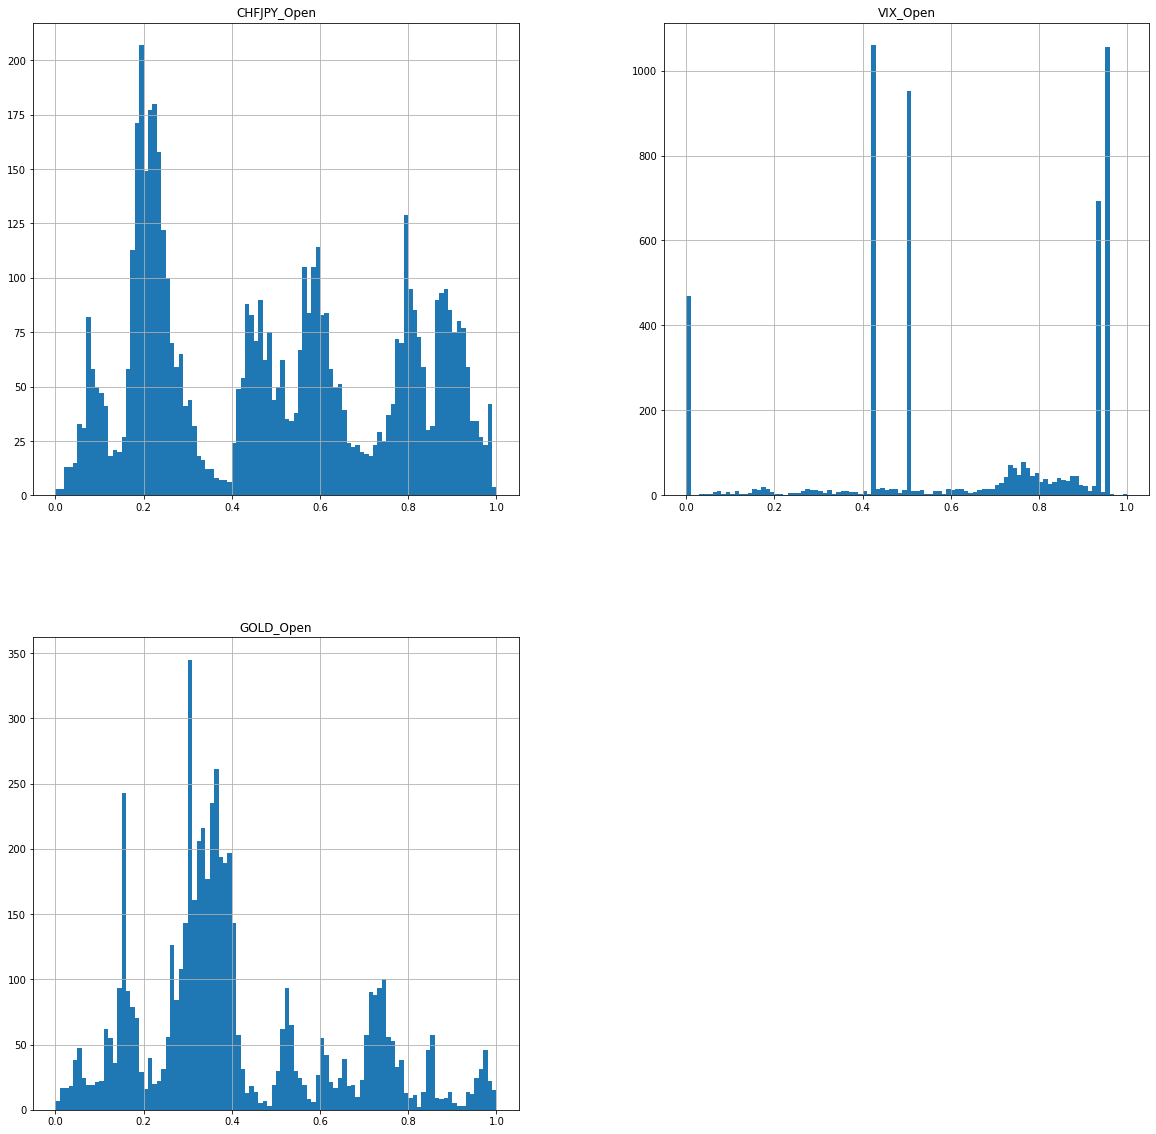

array([[<AxesSubplot:title={'center':'CHFJPY_Vol'}>,
        <AxesSubplot:title={'center':'VIX_Vol'}>],
       [<AxesSubplot:title={'center':'GOLD_Vol'}>, <AxesSubplot:>]],
      dtype=object)

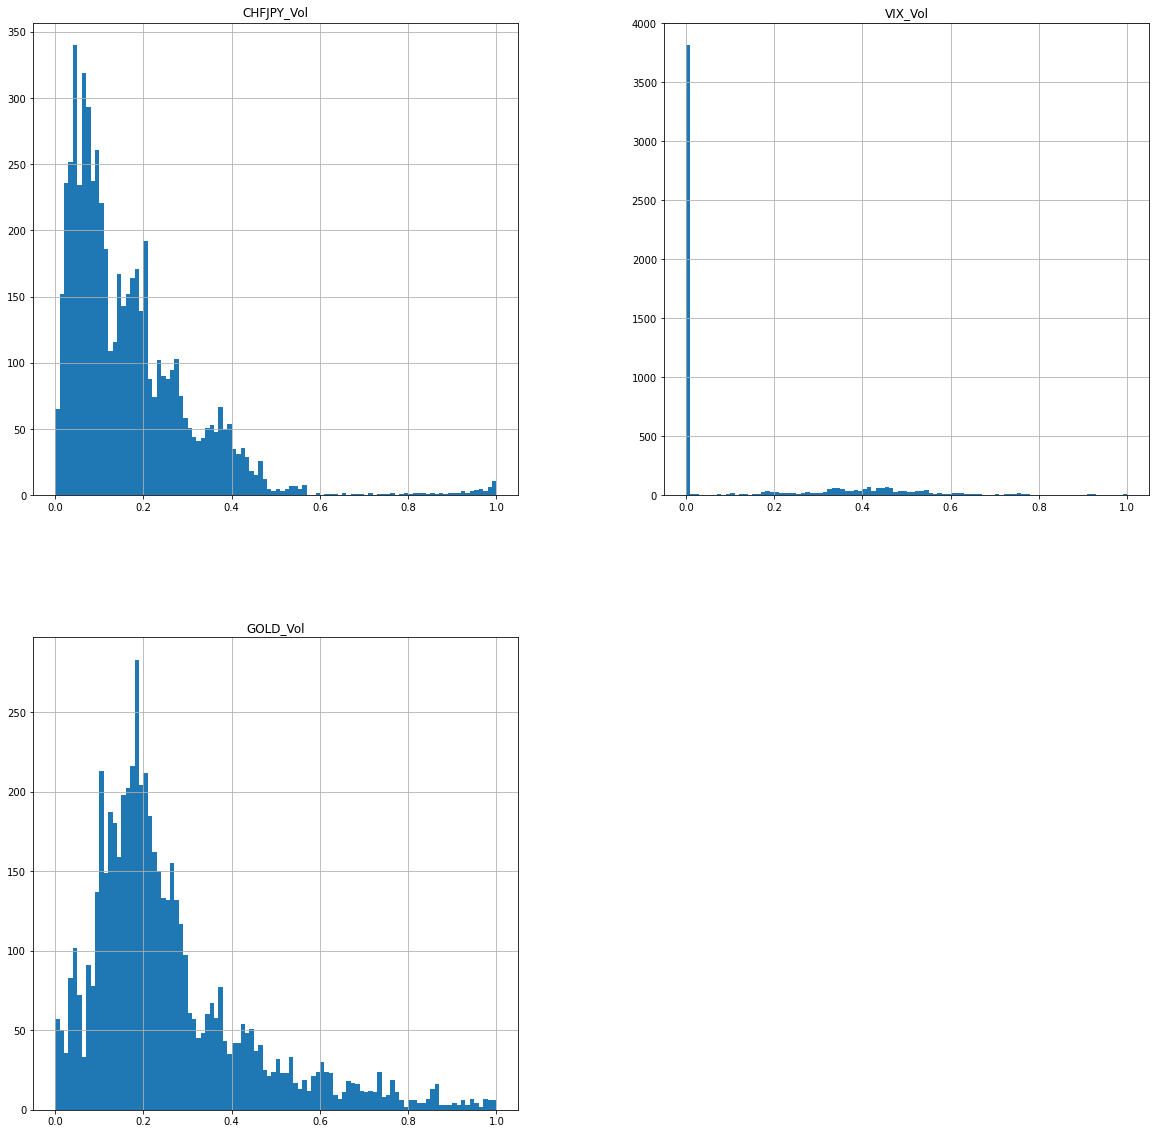

In [11]:
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111)
ax.set_title('Open Histogram')
train[list(filter(lambda x: '_Open' in x, train.columns))].hist(ax=ax, bins=100)
plt.show()
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111)
train[list(filter(lambda x: '_Vol' in x, train.columns))].hist(ax=ax, bins=100)

# Train Batch

In [12]:
trainShifted = train[['CHFJPY_Mean', 'CHFJPY_Vol', 'VIX_Vol', 'VIX_Mean', 'GOLD_Vol', 'GOLD_Mean']]
SHIFT_ARRAY = [5, 10, 15, 20, 40, 60]
trainColumns = trainShifted.columns
for sf in SHIFT_ARRAY:
    shifted = trainShifted.shift(sf)
    for column in trainColumns:
        trainShifted[f"SHIFTED_{sf}_{column}"] = shifted[column]
del trainColumns
trainShifted = trainShifted.iloc[max(SHIFT_ARRAY):]
train = train.iloc[max(SHIFT_ARRAY):]
train = train.merge(trainShifted[list(filter(lambda x: x not in train.columns, trainShifted.columns))], left_index=True, right_index=True)
train

/var/folders/_r/6hvfrncn0gb3rk22vwnq62gh0000gn/T/ipykernel_1448/1358549267.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trainShifted[f"SHIFTED_{sf}_{column}"] = shifted[column]


,CHFJPY_Open,VIX_Open,FiniteVixData,GOLD_Open,FiniteGOLDData,CHFJPY_Vol,CHFJPY_Mean,VIX_Vol,VIX_Mean,GOLD_Vol,...,SHIFTED_40_VIX_Vol,SHIFTED_40_VIX_Mean,SHIFTED_40_GOLD_Vol,SHIFTED_40_GOLD_Mean,SHIFTED_60_CHFJPY_Mean,SHIFTED_60_CHFJPY_Vol,SHIFTED_60_VIX_Vol,SHIFTED_60_VIX_Mean,SHIFTED_60_GOLD_Vol,SHIFTED_60_GOLD_Mean
Datetime,,,,,,,,,,,,,,,,,,,,,
2022-04-22 07:40:00+01:00,0.820329,0.000000,1.0,0.984560,0.0,0.182818,0.873573,0.000000e+00,0.000000,0.192257,...,0.000000e+00,0.000000,0.060068,0.983282,0.957441,0.269572,0.000000e+00,0.000000,0.097698,0.979490
2022-04-22 07:41:00+01:00,0.832709,0.000000,1.0,0.984560,0.0,0.181055,0.872881,0.000000e+00,0.000000,0.192865,...,0.000000e+00,0.000000,0.064435,0.983547,0.956293,0.265708,0.000000e+00,0.000000,0.095963,0.979628
2022-04-22 07:42:00+01:00,0.827832,0.000000,1.0,0.980996,0.0,0.180513,0.872307,0.000000e+00,0.000000,0.193195,...,0.000000e+00,0.000000,0.072016,0.983862,0.955116,0.261905,0.000000e+00,0.000000,0.093568,0.979843
2022-04-22 07:43:00+01:00,0.819207,0.000000,1.0,0.976247,0.0,0.180352,0.871645,0.000000e+00,0.000000,0.192383,...,0.000000e+00,0.000000,0.076801,0.984114,0.953829,0.257207,0.000000e+00,0.000000,0.091360,0.980032
2022-04-22 07:44:00+01:00,0.808704,0.000000,1.0,0.979809,0.0,0.181589,0.871083,0.000000e+00,0.000000,0.192262,...,0.000000e+00,0.000000,0.086013,0.984592,0.952530,0.251590,0.000000e+00,0.000000,0.088713,0.980233
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-28 08:24:00+01:00,0.844711,0.930444,1.0,0.133017,0.0,0.319241,0.844135,7.531670e-07,0.974585,0.581157,...,7.531670e-07,0.974585,0.185720,0.000151,0.700409,0.436940,7.531670e-07,0.974585,0.246950,0.005480
2022-04-28 08:25:00+01:00,0.877718,0.930444,1.0,0.133017,0.0,0.317427,0.845610,7.531670e-07,0.974585,0.586095,...,7.531670e-07,0.974585,0.187774,0.000290,0.702496,0.440748,7.531670e-07,0.974585,0.246258,0.005002
2022-04-28 08:26:00+01:00,0.878473,0.930444,1.0,0.156770,0.0,0.315406,0.847097,7.531670e-07,0.974585,0.597328,...,7.531670e-07,0.974585,0.188996,0.000365,0.704461,0.442682,7.531670e-07,0.974585,0.245091,0.004548


# Test Batch

In [13]:
testB = test
testB[testB.columns] = scalePandas.transform(testB[testB.columns])
testShifted = testB[['CHFJPY_Mean', 'CHFJPY_Vol', 'VIX_Vol', 'VIX_Mean', 'GOLD_Vol', 'GOLD_Mean']]
SHIFT_ARRAY = [5, 10, 15, 20, 40, 60]
trainColumns = testShifted.columns
for sf in SHIFT_ARRAY:
    shifted = testShifted.shift(sf)
    for column in trainColumns:
        testShifted[f"SHIFTED_{sf}_{column}"] = shifted[column]
del trainColumns
testShifted = testShifted.iloc[max(SHIFT_ARRAY):]
testB = testB.iloc[max(SHIFT_ARRAY):]
testB = testB.merge(testShifted[list(filter(lambda x: x not in testB.columns, testShifted.columns))], left_index=True, right_index=True)
testB

/var/folders/_r/6hvfrncn0gb3rk22vwnq62gh0000gn/T/ipykernel_1448/264019191.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testShifted[f"SHIFTED_{sf}_{column}"] = shifted[column]


,CHFJPY_Open,VIX_Open,FiniteVixData,GOLD_Open,FiniteGOLDData,CHFJPY_Vol,CHFJPY_Mean,VIX_Vol,VIX_Mean,GOLD_Vol,...,SHIFTED_40_VIX_Vol,SHIFTED_40_VIX_Mean,SHIFTED_40_GOLD_Vol,SHIFTED_40_GOLD_Mean,SHIFTED_60_CHFJPY_Mean,SHIFTED_60_CHFJPY_Vol,SHIFTED_60_VIX_Vol,SHIFTED_60_VIX_Mean,SHIFTED_60_GOLD_Vol,SHIFTED_60_GOLD_Mean
Datetime,,,,,,,,,,,,,,,,,,,,,
2022-04-28 09:29:00+01:00,1.043510,0.930444,1.0,0.092637,0.0,0.499875,1.001211,7.531670e-07,0.974585,0.239625,...,7.531670e-07,0.974585,0.648925,0.062337,0.851434,0.311645,7.531670e-07,0.974585,0.624828,0.036535
2022-04-28 09:30:00+01:00,1.069019,0.930444,1.0,0.104514,0.0,0.496079,1.003973,7.531670e-07,0.974585,0.235943,...,7.531670e-07,0.974585,0.643867,0.063496,0.852985,0.307807,7.531670e-07,0.974585,0.635619,0.037770
2022-04-28 09:31:00+01:00,1.076523,0.930444,1.0,0.108076,0.0,0.496946,1.006315,7.531670e-07,0.974585,0.227363,...,7.531670e-07,0.974585,0.637931,0.064567,0.854586,0.305358,7.531670e-07,0.974585,0.647302,0.039030
2022-04-28 09:32:00+01:00,1.063015,0.930444,1.0,0.116390,0.0,0.496541,1.008482,7.531670e-07,0.974585,0.215149,...,7.531670e-07,0.974585,0.632427,0.065562,0.856220,0.310397,7.531670e-07,0.974585,0.656710,0.040290
2022-04-28 09:33:00+01:00,1.042760,0.930444,1.0,0.103326,0.0,0.494448,1.010426,7.531670e-07,0.974585,0.209074,...,7.531670e-07,0.974585,0.627924,0.066696,0.857791,0.315732,7.531670e-07,0.974585,0.665991,0.041550
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-29 16:30:00+01:00,0.510877,0.755040,0.0,0.399049,0.0,0.729789,0.702110,4.982546e-01,0.764526,0.368196,...,4.330380e-01,0.725701,0.405097,0.431824,0.771555,0.201486,2.918492e-01,0.705048,0.388376,0.429619
2022-04-29 16:31:00+01:00,0.509006,0.738911,0.0,0.404987,0.0,0.738357,0.699315,4.969103e-01,0.765044,0.368449,...,4.385234e-01,0.726863,0.407068,0.431975,0.772259,0.198532,3.005305e-01,0.705977,0.388266,0.429795
2022-04-29 16:32:00+01:00,0.520258,0.730847,0.0,0.401425,0.0,0.745469,0.696675,4.961432e-01,0.765361,0.370649,...,4.454996e-01,0.728141,0.408216,0.432076,0.773005,0.196090,3.071235e-01,0.706822,0.388111,0.429921


# Forest

In [14]:
data = train.drop(['Target', 'CHFJPY_Mean_Future'], axis=1).values
target = train.Target
testData = testB.drop(['Target', 'CHFJPY_Mean_Future'], axis=1).values
testTarget = testB.Target

In [15]:
forest = RandomForestClassifier(verbose=1, n_estimators=20, min_samples_leaf=43, criterion='entropy', n_jobs=-1,
                                max_depth=34, min_samples_split=40)
forest.fit(X=data, y=target)
# Train Score
print('Train Score', forest.score(X=data, y=target))

# Test Score
print('Test Score', forest.score(X=testData, y=testTarget))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    0.0s finished


Train Score 0.9558952732384467
Test Score 0.6628971459343026


# Ridge Classifier

In [16]:
classifier = SKmodels.RidgeClassifier(alpha=.3, solver='lsqr')
classifier.fit(X=data, y=target)
# Train Score
print('Train Score', classifier.score(X=data, y=target))
# Test Score
print('Test Score', classifier.score(X=testData, y=testTarget))

Train Score 0.8453698822702512
Test Score 0.8572967151319332


In [22]:
list(zip(classifier.coef_, train.drop(['Target'], axis=1).columns))

[(array([ 10.7412732 ,   0.64178656,  -3.47804197,  -2.8040721 ,
           0.82479349,  -1.04800602,   6.43138483,   0.1122793 ,
          -0.72488766,  -1.77282421,   0.23810022,  -0.69493097,
           2.77730822,   0.        ,   0.        ,  -0.88555407,
           0.02697745,  -0.35800456,   0.        ,   0.        ,
           0.61374396,  -0.1305127 ,   0.        ,  -0.02098858,
          -1.50907737,  -0.03633075,   1.03497833,   0.        ,
           0.        ,   0.        ,  -8.40031702,  -1.28161753,
           0.64706336,   1.57896343,   0.        ,   0.33202048,
         -11.03606761,   1.0921218 ,   1.83871307,   4.03175813,
          -0.2062122 ,   2.18417374]),
  'CHFJPY_Open')]

In [18]:
pd.Series(index=list(train.drop(['Target', 'CHFJPY_Mean_Future'], axis=1).columns), data=classifier.coef_[0])

CHFJPY_Open               7.111877
VIX_Open                 -1.288885
FiniteVixData             0.082742
GOLD_Open                -0.143640
FiniteGOLDData            0.083848
CHFJPY_Vol               -0.314843
CHFJPY_Mean               1.344482
VIX_Vol                  -0.686069
VIX_Mean                 -0.129534
GOLD_Vol                 -0.156396
GOLD_Mean                -0.123958
SHIFTED_5_CHFJPY_Mean     0.534193
SHIFTED_5_CHFJPY_Vol     -0.039673
SHIFTED_5_VIX_Vol        -0.068415
SHIFTED_5_VIX_Mean       -0.024276
SHIFTED_5_GOLD_Vol        0.018604
SHIFTED_5_GOLD_Mean      -0.105037
SHIFTED_10_CHFJPY_Mean   -0.151037
SHIFTED_10_CHFJPY_Vol     0.196173
SHIFTED_10_VIX_Vol        0.282112
SHIFTED_10_VIX_Mean       0.052149
SHIFTED_10_GOLD_Vol       0.134413
SHIFTED_10_GOLD_Mean     -0.084461
SHIFTED_15_CHFJPY_Mean   -0.719269
SHIFTED_15_CHFJPY_Vol     0.194423
SHIFTED_15_VIX_Vol        0.382614
SHIFTED_15_VIX_Mean       0.098152
SHIFTED_15_GOLD_Vol       0.155956
SHIFTED_15_GOLD_Mean

In [19]:
print(classifier.predict(testData))

[1. 1. 1. ... 0. 0. 0.]


In [20]:
classifier = SKmodels.LogisticRegression(penalty='elasticnet', l1_ratio=0.4, C=0.5, solver='saga')
classifier.fit(X=trainShifted.values, y=train.Target)
# Train Score
print('Train Score', classifier.score(X=trainShifted.values, y=train.Target))
# Test Score
print('Test Score', classifier.score(X=testShifted.values, y=testB.Target))

Train Score 0.7972236865225795
Test Score 0.7129779213785676


In [23]:
import warnings


def make_score(value):
    warnings.filterwarnings("ignore")
    merged = CHFJPY.merge(VIX, left_index=True, right_index=True, how='left')
    nan = np.any(merged.isna(), axis=1)
    nan = nan.where(np.logical_not(nan)).first_valid_index()
    merged = merged.loc[nan:]
    merged['FiniteVixData'] = np.any(merged.isna(), axis=1)[nan:]
    merged[VIX.columns] = merged[VIX.columns].fillna(method='ffill')

    merged = merged.merge(GOLD, left_index=True, right_index=True, how='left')
    nan = np.any(merged.isna(), axis=1)
    nan = nan.where(np.logical_not(nan)).first_valid_index()
    merged = merged.loc[nan:]
    merged['FiniteGOLDData'] = np.any(merged.isna(), axis=1)[nan:]
    merged[GOLD.columns] = merged[GOLD.columns].fillna(method='ffill')
    # merged.drop(['CHFJPY_Volume', 'CHFJPY_Dividends',
    #              'CHFJPY_Stock Splits', 'VIX_Volume', 'VIX_Dividends', 'VIX_Stock Splits',
    #              'GOLD_Stock Splits', 'GOLD_Dividends', 'GOLD_Volume'],
    #             axis=1, inplace=True)

    del nan
    # Create Mean by rolling on rollParam value.
    rollParam = 100
    CHFJPY_roll = merged.rolling(rollParam)['CHFJPY_Open']
    merged['CHFJPY_Vol'] = CHFJPY_roll.std()
    merged['CHFJPY_Mean'] = CHFJPY_roll.mean()

    VIX_roll = merged.rolling(rollParam)['VIX_Open']
    merged['VIX_Vol'] = VIX_roll.std()
    merged['VIX_Mean'] = VIX_roll.mean()

    GOLD_roll = merged.rolling(rollParam)['GOLD_Open']
    merged['GOLD_Vol'] = GOLD_roll.std()
    merged['GOLD_Mean'] = GOLD_roll.mean()

    merged = merged.iloc[rollParam:]

    predictionMean = value
    merged['CHFJPY_Mean_Future'] = merged['CHFJPY_Mean'].shift(-predictionMean)
    merged = merged.iloc[:-predictionMean]
    del CHFJPY_roll, VIX_roll, GOLD_roll
    merged['Target'] = merged.apply(lambda x: 1 if x.CHFJPY_Mean_Future > x['CHFJPY_Mean'] else 0, axis=1)
    train, test = train_test_split(merged, shuffle=False)
    scalePandas = MinMaxScaler()
    train[train.columns] = scalePandas.fit_transform(train[train.columns])
    trainShifted = train[['CHFJPY_Mean', 'CHFJPY_Vol', 'VIX_Vol', 'VIX_Mean', 'GOLD_Vol', 'GOLD_Mean']]
    SHIFT_ARRAY = [5, 10, 15, 20, 40, 60]
    trainColumns = trainShifted.columns
    for sf in SHIFT_ARRAY:
        shifted = trainShifted.shift(sf)
        for column in trainColumns:
            trainShifted[f"SHIFTED_{sf}_{column}"] = shifted[column]
    del trainColumns
    trainShifted = trainShifted.iloc[max(SHIFT_ARRAY):]
    train = train.iloc[max(SHIFT_ARRAY):]
    train = train.merge(trainShifted[list(filter(lambda x: x not in train.columns, trainShifted.columns))], left_index=True, right_index=True)

    testB = test
    testB[testB.columns] = scalePandas.transform(testB[testB.columns])
    testShifted = testB[['CHFJPY_Mean', 'CHFJPY_Vol', 'VIX_Vol', 'VIX_Mean', 'GOLD_Vol', 'GOLD_Mean']]
    SHIFT_ARRAY = [5, 10, 15, 20, 40, 60]
    trainColumns = testShifted.columns
    for sf in SHIFT_ARRAY:
        shifted = testShifted.shift(sf)
        for column in trainColumns:
            testShifted[f"SHIFTED_{sf}_{column}"] = shifted[column]
    del trainColumns
    testShifted = testShifted.iloc[max(SHIFT_ARRAY):]
    testB = testB.iloc[max(SHIFT_ARRAY):]
    testB = testB.merge(testShifted[list(filter(lambda x: x not in testB.columns, testShifted.columns))], left_index=True, right_index=True)
    data = train.drop(['Target', 'CHFJPY_Mean_Future'], axis=1).values
    target = train.Target
    testData = testB.drop(['Target', 'CHFJPY_Mean_Future'], axis=1).values
    testTarget = testB.Target
    classifier = SKmodels.RidgeClassifier(alpha=.3, solver='lsqr')
    classifier.fit(X=data, y=target)
    return [value, classifier.score(X=testData, y=testTarget)]

with pd.option_context('mode.chained_assignment',None):
    RES = joblib.Parallel(n_jobs=-1, verbose=10)(joblib.delayed(make_score)(x) for x in list(range(10, 400, 5)))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done  78 out of  78 | elapsed:   15.8s finished


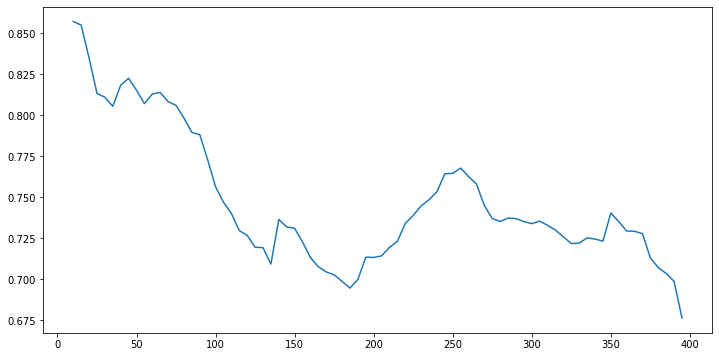

In [24]:
plt.figure(figsize=(12,6))
plt.plot([x[0] for x in RES], [x[1] for x in RES])